# TMVA_Higgs_Classification
Classification example of TMVA based on public Higgs UCI dataset

 The UCI data set is a public HIGGS data set , see http://archive.ics.uci.edu/ml/datasets/HIGGS
used in this paper: Baldi, P., P. Sadowski, and D. Whiteson. “Searching for Exotic Particles in High-energy Physics
                    with Deep Learning.” Nature Communications 5 (July 2, 2014).




**Author:** Harshal Shende  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Wednesday, April 17, 2024 at 11:22 AM.</small></i>

 Declare Factory

 Create the Factory class. Later you can choose the methods
 whose performance you'd like to investigate.

 The factory is the major TMVA object you have to interact with. Here is the list of parameters you need to pass

 - The first argument is the base of the name of all the output
 weightfiles in the directory weight/ that will be created with the
    method parameters

 - The second argument is the output file for the training results

 - The third argument is a string option defining some general configuration for the TMVA session. For example all TMVA output can be suppressed by removing the "!" (not) in front of the "Silent" argument in the option string

In [1]:
import ROOT
import os

TMVA = ROOT.TMVA
TFile = ROOT.TFile

TMVA.Tools.Instance()

options to control used methods

In [2]:
useLikelihood = True  # likelihood based discriminant
useLikelihoodKDE = False  # likelihood based discriminant
useFischer = True  # Fischer discriminant
useMLP = False  # Multi Layer Perceptron (old TMVA NN implementation)
useBDT = True  # Boosted Decision Tree
useDL = True  # TMVA Deep learning ( CPU or GPU)
useKeras = True  # Use Keras Deep Learning via PyMVA

if ROOT.gSystem.GetFromPipe("root-config --has-tmva-pymva") == "yes":
    TMVA.PyMethodBase.PyInitialize()
else:
    useKeras = False  # cannot use Keras if PYMVA is not available

if useKeras:
    try:
        import tensorflow
    except:
        ROOT.Warning("TMVA_Higgs_Classification", "Skip using Keras since tensorflow is not available")
        useKeras = False

outputFile = TFile.Open("Higgs_ClassificationOutput.root", "RECREATE")
factory = TMVA.Factory(
    "TMVA_Higgs_Classification", outputFile, V=False, ROC=True, Silent=False, Color=True, AnalysisType="Classification"
)

2024-04-17 11:22:41.842904: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 11:22:41.918029: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 11:22:41.919178: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 11:22:43.129425: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


 Setup Dataset(s)

Define now input data file and signal and background trees

In [3]:
inputFileName = "Higgs_data.root"
inputFileLink = "http://root.cern.ch/files/" + inputFileName


if ROOT.gSystem.AccessPathName(inputFileName):
    ROOT.Info("TMVA_Higgs_Classification", "Download Higgs_data.root file")
    TFile.SetCacheFileDir(".")
    inputFile = TFile.Open(inputFileLink, "CACHEREAD")
    if inputFile is None:
        raise FileNotFoundError("Input file cannot be downloaded - exit")
else:
    # file exists
    inputFile = TFile.Open(inputFileName)

Info in <TMVA_Higgs_Classification>: Download Higgs_data.root file
[TFile::Cp] Total 1.50 MB	|====================| 100.00 % [70.8 MB/s]
Info in <TFile::OpenFromCache>: using local cache copy of http://root.cern.ch/files/Higgs_data.root [./files/Higgs_data.root]


--- Register the training and test trees

In [4]:
signalTree = inputFile.Get("sig_tree")
backgroundTree = inputFile.Get("bkg_tree")
signalTree.Print()

******************************************************************************
*Tree    :sig_tree  : tree                                                   *
*Entries :    10000 : Total =         1177229 bytes  File  Size =     785298 *
*        :          : Tree compression factor =   1.48                       *
******************************************************************************
*Br    0 :Type      : Type/F                                                 *
*Entries :    10000 : Total  Size=      40556 bytes  File Size  =        307 *
*Baskets :        1 : Basket Size=    1500672 bytes  Compression= 130.54     *
*............................................................................*
*Br    1 :lepton_pT : lepton_pT/F                                            *
*Entries :    10000 : Total  Size=      40581 bytes  File Size  =      30464 *
*Baskets :        1 : Basket Size=    1500672 bytes  Compression=   1.32     *
*...................................................

 Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input variables
Define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

In [5]:
loader = TMVA.DataLoader("dataset")

loader.AddVariable("m_jj")
loader.AddVariable("m_jjj")
loader.AddVariable("m_lv")
loader.AddVariable("m_jlv")
loader.AddVariable("m_bb")
loader.AddVariable("m_wbb")
loader.AddVariable("m_wwbb")

We set now the input data trees in the TMVA DataLoader class
global event weights per tree (see below for setting event-wise weights)

In [6]:
signalWeight = 1.0
backgroundWeight = 1.0

You can add an arbitrary number of signal or background trees

In [7]:
loader.AddSignalTree(signalTree, signalWeight)
loader.AddBackgroundTree(backgroundTree, backgroundWeight)

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree sig_tree of type Signal with 10000 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree bkg_tree of type Background with 10000 events


Set individual event weights (the variables must exist in the original TTree)
  for signal    : factory->SetSignalWeightExpression    ("weight1*weight2");
  for background: factory->SetBackgroundWeightExpression("weight1*weight2");
  loader->SetBackgroundWeightExpression( "weight" );

Apply additional cuts on the signal and background samples (can be different)

In [8]:
mycuts = ROOT.TCut("")  # for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
mycutb = ROOT.TCut("")  # for example: TCut mycutb = "abs(var1)<0.5";

Tell the factory how to use the training and testing events

If no numbers of events are given, half of the events in the tree are used
for training, and the other half for testing:
   loader->PrepareTrainingAndTestTree( mycut, "SplitMode=random:!V" );
To also specify the number of testing events, use:

In [9]:
loader.PrepareTrainingAndTestTree(
    mycuts, mycutb, nTrain_Signal=7000, nTrain_Background=7000, SplitMode="Random", NormMode="NumEvents", V=False
)

 Booking Methods

Here we book the TMVA methods. We book first a Likelihood based on KDE (Kernel Density Estimation), a Fischer discriminant, a BDT
and a shallow neural network
Likelihood ("naive Bayes estimator")

In [10]:
if useLikelihood:
    factory.BookMethod(
        loader,
        TMVA.Types.kLikelihood,
        "Likelihood",
        H=True,
        V=False,
        TransformOutput=True,
        PDFInterpol="Spline2:NSmoothSig[0]=20:NSmoothBkg[0]=20:NSmoothBkg[1]=10",
        NSmooth=1,
        NAvEvtPerBin=50,
    )

Factory                  : Booking method: Likelihood
                         : 


Use a kernel density estimator to approximate the PDFs

In [11]:
if useLikelihoodKDE:
    factory.BookMethod(
        loader,
        TMVA.Types.kLikelihood,
        "LikelihoodKDE",
        H=False,
        V=False,
        TransformOutput=False,
        PDFInterpol="KDE",
        KDEtype="Gauss",
        KDEiter="Adaptive",
        KDEFineFactor=0.3,
        KDEborder=None,
        NAvEvtPerBin=50,
    )

Fisher discriminant (same as LD)

In [12]:
if useFischer:
    factory.BookMethod(
        loader,
        TMVA.Types.kFisher,
        "Fisher",
        H=True,
        V=False,
        Fisher=True,
        VarTransform=None,
        CreateMVAPdfs=True,
        PDFInterpolMVAPdf="Spline2",
        NbinsMVAPdf=50,
        NsmoothMVAPdf=10,
    )

Factory                  : Booking method: Fisher
                         : 


Boosted Decision Trees

In [13]:
if useBDT:
    factory.BookMethod(
        loader,
        TMVA.Types.kBDT,
        "BDT",
        V=False,
        NTrees=200,
        MinNodeSize="2.5%",
        MaxDepth=2,
        BoostType="AdaBoost",
        AdaBoostBeta=0.5,
        UseBaggedBoost=True,
        BaggedSampleFraction=0.5,
        SeparationType="GiniIndex",
        nCuts=20,
    )

Factory                  : Booking method: BDT
                         : 
                         : Rebuilding Dataset dataset
                         : Building event vectors for type 2 Signal
                         : Dataset[dataset] :  create input formulas for tree sig_tree
                         : Building event vectors for type 2 Background
                         : Dataset[dataset] :  create input formulas for tree bkg_tree
DataSetFactory           : [dataset] : Number of events in input trees
                         : 
                         : 
                         : Number of training and testing events
                         : ---------------------------------------------------------------------------
                         : Signal     -- training events            : 7000
                         : Signal     -- testing events             : 3000
                         : Signal     -- training and testing events: 10000
                         : Backgroun

Multi-Layer Perceptron (Neural Network)

In [14]:
if useMLP:
    factory.BookMethod(
        loader,
        TMVA.Types.kMLP,
        "MLP",
        H=False,
        V=False,
        NeuronType="tanh",
        VarTransform="N",
        NCycles=100,
        HiddenLayers="N+5",
        TestRate=5,
        UseRegulator=False,
    )

 Here we book the new DNN of TMVA if we have support in ROOT. We will use GPU version if ROOT is enabled with GPU

 Booking Deep Neural Network

Here we define the option string for building the Deep Neural network model.

## 1. Define DNN layout

The DNN configuration is defined using a string. Note that whitespaces between characters are not allowed.

We define first the DNN layout:

- **input layout** :   this defines the input data format for the DNN as  ``input depth | height | width``.
In case of a dense layer as first layer the input layout should be  ``1 | 1 | number of input variables`` (features)
- **batch layout**  : this defines how are the input batch. It is related to input layout but not the same.
If the first layer is dense it should be ``1 | batch size ! number of variables`` (features)

*(note the use of the character `|` as  separator of  input parameters for DNN layout)*

note that in case of only dense layer the input layout could be omitted but it is required when defining more
complex architectures

- **layer layout** string defining the layer architecture. The syntax is
- layer type (e.g. DENSE, CONV, RNN)
- layer parameters (e.g. number of units)
- activation function (e.g  TANH, RELU,...)

*the different layers are separated by the ``","`` *

## 2. Define Training Strategy

We define here the training strategy parameters for the DNN. The parameters are separated by the ``","`` separator.
One can then concatenate different training strategy with different parameters. The training strategy are separated by
the ``"|"`` separator.

- Optimizer
- Learning rate
- Momentum (valid for SGD and RMSPROP)
- Regularization and Weight Decay
- Dropout
- Max number of epochs
- Convergence steps. if the test error will not decrease after that value the training will stop
- Batch size (This value must be the same specified in the input layout)
- Test Repetitions (the interval when the test error will be computed)

## 3. Define general DNN options

We define the general DNN options concatenating in the final string the previously defined layout and training strategy.
Note we use the ``":"`` separator to separate the different higher level options, as in the other TMVA methods.
In addition to input layout, batch layout and training strategy we add now:

- Type of Loss function (e.g. CROSSENTROPY)
- Weight Initizalization (e.g XAVIER, XAVIERUNIFORM, NORMAL )
- Variable Transformation
- Type of Architecture (e.g. CPU, GPU, Standard)

We can then book the DL method using the built option string

In [15]:
if useDL:
    useDLGPU = ROOT.gSystem.GetFromPipe("root-config --has-tmva-gpu") == "yes"

    # Define DNN layout
    # Define Training strategies
    # one can catenate several training strategies
    training1 = ROOT.TString(
        "LearningRate=1e-3,Momentum=0.9,"
        "ConvergenceSteps=10,BatchSize=128,TestRepetitions=1,"
        "MaxEpochs=20,WeightDecay=1e-4,Regularization=None,"
        "Optimizer=ADAM,ADAM_beta1=0.9,ADAM_beta2=0.999,ADAM_eps=1.E-7,"  # ADAM default parameters
        "DropConfig=0.0+0.0+0.0+0."
    )
    #   training2 = ROOT.TString("LearningRate=1e-3,Momentum=0.9"
    #                      "ConvergenceSteps=10,BatchSize=128,TestRepetitions=1,"
    #                       "MaxEpochs=20,WeightDecay=1e-4,Regularization=None,"
    #                       "Optimizer=SGD,DropConfig=0.0+0.0+0.0+0.")

    # General Options.
    dnnMethodName = ROOT.TString("DNN_CPU")

    if useDLGPU:
        arch = "GPU"
        dnnMethodName = "DNN_GPU"
    else:
        arch = "CPU"

    factory.BookMethod(
        loader,
        TMVA.Types.kDL,
        dnnMethodName,
        H=False,
        V=True,
        ErrorStrategy="CROSSENTROPY",
        VarTransform="G",
        WeightInitialization="XAVIER",
        InputLayout="1|1|7",
        BatchLayout="1|128|7",
        Layout="DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|1|LINEAR",
        TrainingStrategy=training1,
        Architecture=arch,
    )

Factory                  : Booking method: DNN_CPU
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=G:WeightInitialization=XAVIER:InputLayout=1|1|7:BatchLayout=1|128|7:Layout=DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|1|LINEAR:TrainingStrategy=LearningRate=1e-3,Momentum=0.9,ConvergenceSteps=10,BatchSize=128,TestRepetitions=1,MaxEpochs=20,WeightDecay=1e-4,Regularization=None,Optimizer=ADAM,ADAM_beta1=0.9,ADAM_beta2=0.999,ADAM_eps=1.E-7,DropConfig=0.0+0.0+0.0+0.:Architecture=CPU"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransf

Keras DL

In [16]:
if useKeras:
    ROOT.Info("TMVA_Higgs_Classification", "Building Deep Learning keras model")
    # create Keras model with 4 layers of 64 units and relu activations
    import tensorflow
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.layers import Input, Dense

    model = Sequential()
    model.add(Dense(64, activation="relu", input_dim=7))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(2, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), weighted_metrics=["accuracy"])
    model.save("model_higgs.h5")
    model.summary()

    if not os.path.exists("model_higgs.h5"):
        raise FileNotFoundError("Error creating Keras model file - skip using Keras")
    else:
        # book PyKeras method only if Keras model could be created
        ROOT.Info("TMVA_Higgs_Classification", "Booking Deep Learning keras model")
        factory.BookMethod(
            loader,
            TMVA.Types.kPyKeras,
            "PyKeras",
            H=True,
            V=False,
            VarTransform=None,
            FilenameModel="model_higgs.h5",
            FilenameTrainedModel="trained_model_higgs.h5",
            NumEpochs=20,
            BatchSize=100,
        )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 13122 (51.26 KB)
Trainable params: 13122 (51.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Factory                  : Booking method: PyKeras
                         : 
                         : Setting up tf.keras
                         : Using TensorFlow version 2
                         : Use Keras version from TensorFlow : tf.keras
                         :  Loading Keras Model 
                         : Loaded model from file: model_higgs.h5


Info in <TMVA_Higgs_Classification>: Building Deep Learning keras model
Info in <TMVA_Higgs_Classification>: Booking Deep Learning keras model


           GpuOptions="allow_growth=True",
       )  # needed for RTX NVidia card and to avoid TF allocates all GPU memory

 Train Methods

Here we train all the previously booked methods.

In [17]:
factory.TrainAllMethods()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 13122 (51.26 KB)
Trainable params: 13122 (51.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
109/112 [

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Factory                  : Train all methods
Factory                  : [dataset] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'm_jj' <---> Output : variable 'm_jj'
                         : Input : variable 'm_jjj' <---> Output : variable 'm_jjj'
                         : Input : variable 'm_lv' <---> Output : variable 'm_lv'
                         : Input : variable 'm_jlv' <---> Output : variable 'm_jlv'
                         : Input : variable 'm_bb' <---> Output : variable 'm_bb'
                         : Input : variable 'm_wbb' <---> Output : variable 'm_wbb'
                         : Input : variable 'm_wwbb' <---> Output : variable 'm_wwbb'
TFHandler_Factory        : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
         

0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time 

 Test  all methods

Now we test and evaluate all methods using the test data set

In [18]:
factory.TestAllMethods()

factory.EvaluateAllMethods()

Factory                  : Test all methods
Factory                  : Test method: Likelihood for Classification performance
                         : 
Likelihood               : [dataset] : Evaluation of Likelihood on testing sample (6000 events)
                         : Elapsed time for evaluation of 6000 events: 0.0106 sec       
Factory                  : Test method: Fisher for Classification performance
                         : 
Fisher                   : [dataset] : Evaluation of Fisher on testing sample (6000 events)
                         : Elapsed time for evaluation of 6000 events: 0.00199 sec       
                         : Dataset[dataset] : Evaluation of Fisher on testing sample
Factory                  : Test method: BDT for Classification performance
                         : 
BDT                      : [dataset] : Evaluation of BDT on testing sample (6000 events)
                         : Elapsed time for evaluation of 6000 events: 0.046 sec       
Factory 

0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time 

after we get the ROC curve and we display

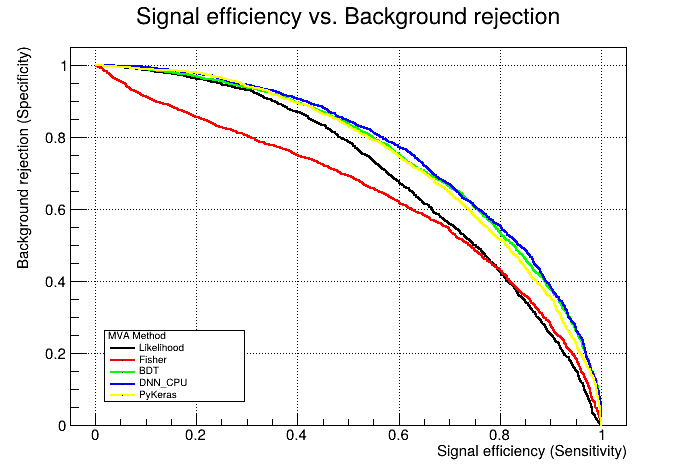

In [19]:
c1 = factory.GetROCCurve(loader)
c1.Draw()

at the end we close the output file which contains the evaluation result of all methods and it can be used by TMVAGUI
to display additional plots

In [20]:
outputFile.Close()

Draw all canvases 

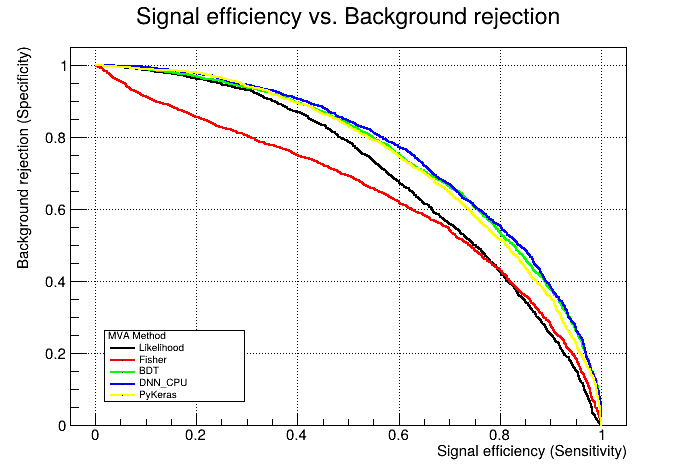

In [21]:
from ROOT import gROOT 
gROOT.GetListOfCanvases().Draw()